# Analysis of Bike Rentals in Washington DC, 2011-2012

Dataset compiled by [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/). 

Download data [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [75]:
import pandas as pd
import numpy as np

data = pd.read_csv("hour.csv")
print(data.columns)
data["dteday"] = pd.to_datetime(data["dteday"],infer_datetime_format=True)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


In [76]:
def assign_hour_label(row):
    labels = [[1,5],[2,11],[3,17],[4,24]]
    hour = row["hr"]
    for l in labels:
        if hour <= l[1]:
            return l[0]
data["time_label"] = data.apply(assign_hour_label, axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


## Split data into test and training sets

In [77]:
training_pct = 0.8
train = data.sample(frac=training_pct, random_state=42)
test = data.iloc[~data.index.isin(train.index.values)]
print(train.shape)
print(test.shape)
print(data.shape)

(13903, 18)
(3476, 18)
(17379, 18)


## Plot some charts to get sense of data

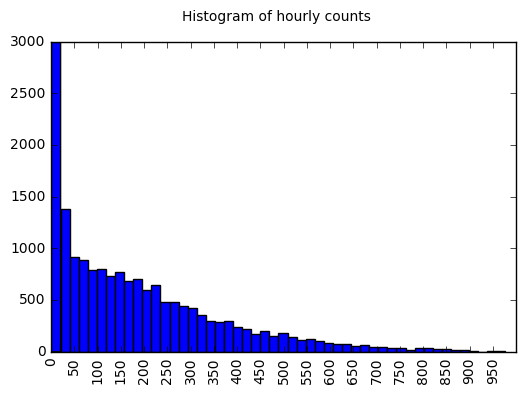

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data["cnt"],bins=50)
plt.suptitle("Histogram of hourly counts")
plt.xticks([x for x in range(0,1000,50)],rotation=90)
plt.show()

In [79]:
data.describe()["cnt"]

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [80]:
data.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
time_label    0.422126
Name: cnt, dtype: float64

## Apply Linear Regression to Dataset

### Step 1: Select features and fit Model

Since time of the day, humidity and temperature have strong correlations with count, let's select them as features for our linear regression model

In [86]:
feature_columns = ["hum","time_label","temp","hr","season","mnth"]
target_column = "cnt"
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train[feature_columns],train[target_column])
predictions_train = model.predict(train[feature_columns])

### Step 2: Visualize the Model on training data

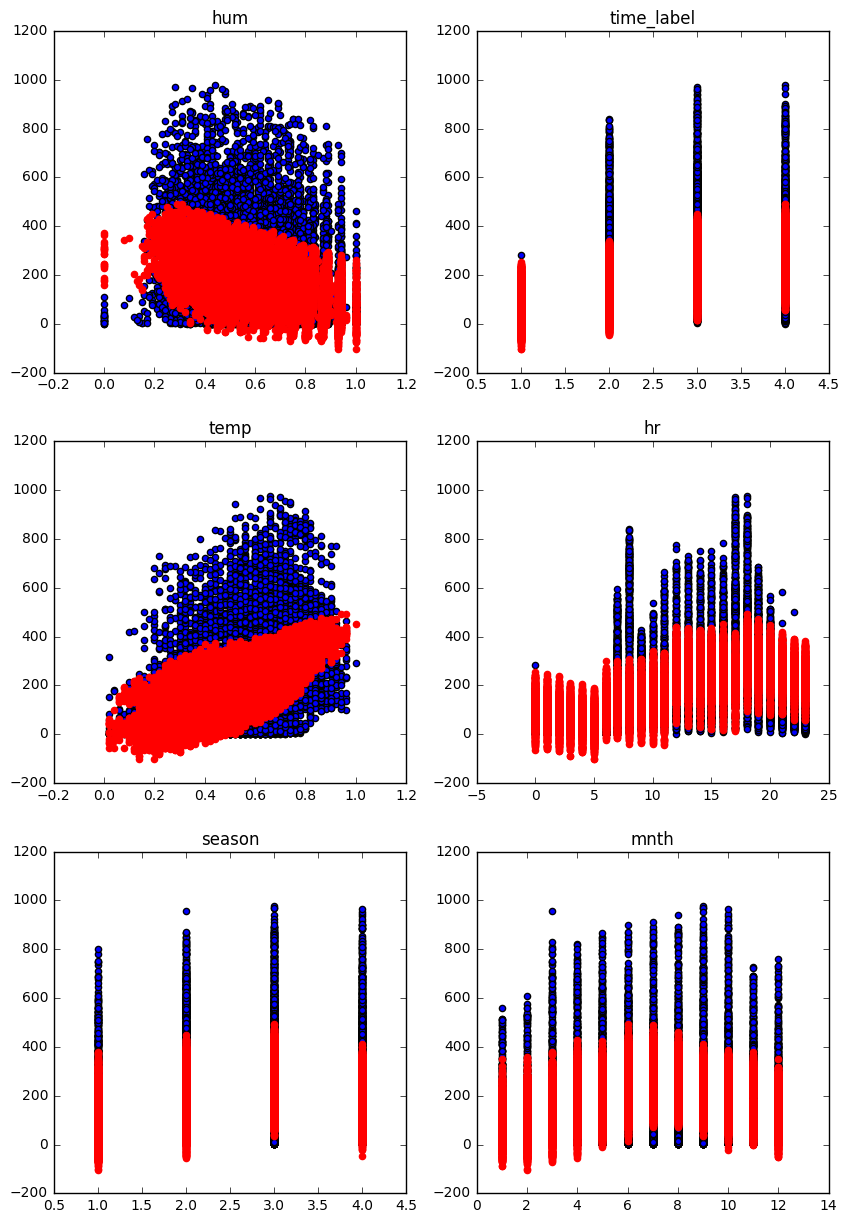

In [89]:
fig = plt.figure(figsize=(10,15))

for i, col in enumerate(feature_columns):
    ax = fig.add_subplot(np.round(len(feature_columns)/2),2,i+1)
    ax.scatter(train[col],train["cnt"])
    ax.scatter(train[col],predictions_train,color="r")
    ax.set_title(col)
plt.show()

### Step 3: Test model on test dataset

In [90]:
from sklearn.metrics import mean_squared_error
predictions_test = model.predict(test[feature_columns])
rmse = (mean_squared_error(test["cnt"],predictions_test))**(1/2)
std = np.std(test["cnt"])
print("Std: {0}, RMSE: {1}".format(std,rmse))
print(test.describe()["cnt"])


Std: 184.49682353538674, RMSE: 148.37160478549535
count    3476.000000
mean      190.586881
std       184.523368
min         1.000000
25%        41.000000
50%       140.500000
75%       277.000000
max       976.000000
Name: cnt, dtype: float64


The RMSE (root mean squared error) is 19% lower than the standard deviation of the test data set. 

**However, the mean error value of 148 is too high for predictive value, especially as 50% of our test dataset has actual values of 140.5 or below. **


### Applying a Decision Tree Model

In [95]:
from sklearn.tree import DecisionTreeRegressor
feature_columns = list(data.columns)
feature_columns.remove("cnt")
feature_columns.remove("casual")
feature_columns.remove("registered")
feature_columns.remove("instant")
feature_columns.remove("dteday")
model = DecisionTreeRegressor(min_samples_leaf=5, random_state=42).fit(train[feature_columns],train[target_column])
predictions_test = model.predict(test[feature_columns])
rmse = (mean_squared_error(test["cnt"],predictions_test))**(1/2)
print("RMSE: {0}".format(rmse))


RMSE: 53.112183942322446


### Applying a Random Forest Model

In [96]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10, max_features=None, min_samples_leaf=5, random_state=42).fit(train[feature_columns],train[target_column])
predictions_test = model.predict(test[feature_columns])
rmse = (mean_squared_error(test["cnt"],predictions_test))**(1/2)
print("RMSE: {0}".format(rmse))

RMSE: 48.938036465313594


** With the random forest model, MSE is significantly reduced vs the regression model, by 68% **